In [52]:
import torch
from torch.utils.data import DataLoader
from training_functions import train
from encoders.dgcnn import ChamferLoss
from dataset import PointCloudDatasetAllBoth
from autoencoder import GraphAutoEncoder
from chamfer import ChamferLoss1
import argparse
from modelnet_dataset import MN_Dataset
import os

root_dir = '/home/mvries/Documents/Datasets/'
path = '/run/user/1128299809/gvfs/smb-share:server=rds.icr.ac.uk,share=data/DBI/DUDBI/DYNCESYS/mvries/ResultsAlma/TearingNetNew/shapenet/nets/dgcnn_foldingnet_50_004.pt'

In [53]:
model = GraphAutoEncoder(num_features=50, k=20, encoder_type="dgcnn", decoder_type='foldingnet')
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])
train_dataset = MN_Dataset(
        root=root_dir,
        dataset_name='modelnet40',
        split='all',
        num_points=2048,
        random_translate=True,
        random_rotate=True,
        random_jitter=True
    )
dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=1,
        shuffle=False,
    )

In [54]:
checkpoint['loss']

31.730517052845347

In [55]:
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
all_feat = []
all_outputs = []
all_inputs = []
labels = []
for data in tqdm(dataloader):
    inputs = data[0]
    lab = data[1]
    inputs = inputs.to(device)
    batch_size = inputs.shape[0]

    output, features = model(inputs)
    all_inputs.append(torch.squeeze(inputs).detach().cpu().numpy())
    all_outputs.append(torch.squeeze(output).detach().cpu().numpy())
    all_feat.append(torch.squeeze(features).detach().cpu().numpy())
    labels.append(lab.numpy())

100%|██████████| 12311/12311 [03:43<00:00, 55.15it/s]


In [56]:
newlab = []
for i in range(len(labels)):
    newlab.append(labels[i][0][0])

In [57]:
import umap
from sklearn import manifold
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
scaled_features = scalar.fit_transform(all_feat)
# UMAP for vizualization
reducer = umap.UMAP()
# embedding = reducer.fit_transform(scaled_features)
embedding = reducer.fit_transform(scaled_features)

/home/mvries/anaconda3/envs/dcc/lib/python3.8/site-packages/umap/spectral.py:343: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


/home/mvries/.local/lib/python3.8/site-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


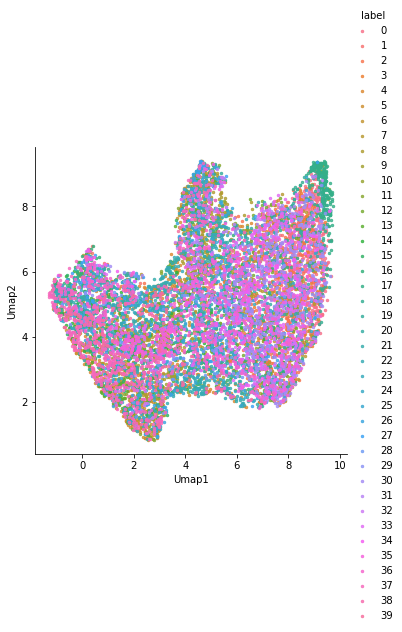

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
%matplotlib inline

b = np.zeros((len(embedding), 2))
b[:, 0] = embedding[:, 0]
b[:, 1] = embedding[:, 1]

data = pd.DataFrame(b, columns=['Umap1','Umap2'])
data['label'] = newlab


facet = sns.lmplot(data=data, x='Umap1', y='Umap2', hue = 'label',
                   fit_reg=False, legend=True, legend_out=True, scatter_kws={"s": 6})


plt.show()

In [59]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import plot_confusion_matrix


X_train, X_test, y_train, y_test = train_test_split(scaled_features, 
                                                        newlab,
                                                        random_state=42, 
                                                        test_size=0.33)
    
clf = svm.SVC(kernel='linear', C=1, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))


0.6363967022308439


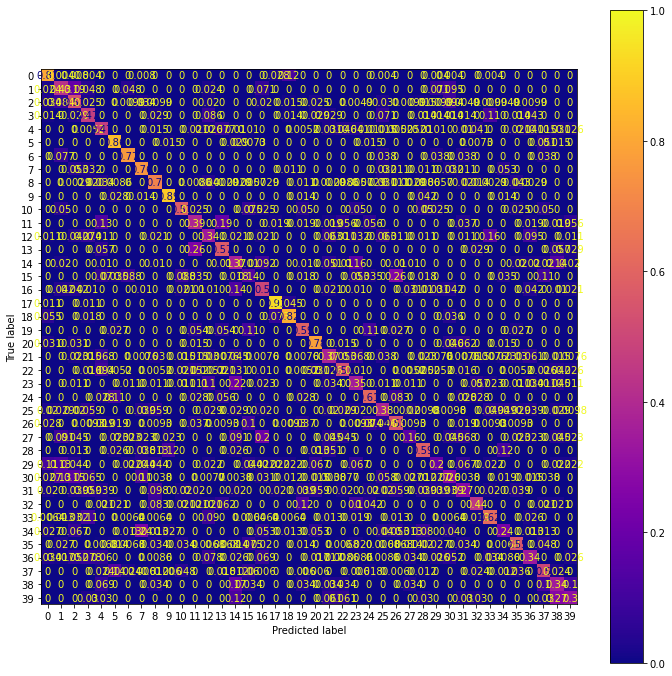

In [60]:
fig, ax = plt.subplots(figsize=(12, 12))
cm = plot_confusion_matrix(clf, X_test, y_test, normalize='true', ax=ax, cmap=plt.cm.plasma)  
cm.ax_.get_images()[0].set_clim(0, 1)
plt.show()